In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from influxdb import InfluxDBClient
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [5]:
df = pd.read_csv('20200124_ews_observations.csv', low_memory=False)


In [6]:
##### pd.to_datetime(df['ObservationDate'])
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171736 entries, 0 to 171735
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   PatientId        171736 non-null  int64         
 1   ObservationDate  171736 non-null  datetime64[ns]
 2   EwsProcedure     171736 non-null  object        
 3   EWS_Total        171736 non-null  int64         
 4   SBP              160949 non-null  float64       
 5   SBP_Score        160949 non-null  float64       
 6   LOC              171736 non-null  object        
 7   LOC_Score        171736 non-null  int64         
 8   SpO2             171734 non-null  float64       
 9   SpO2_Score       171734 non-null  float64       
 10  Add_O2           171734 non-null  object        
 11  Add_O2_Score     171734 non-null  float64       
 12  HR               171736 non-null  int64         
 13  HR_Score         171736 non-null  int64         
 14  RR               171

In [8]:
df.isnull().sum()


PatientId              0
ObservationDate        0
EwsProcedure           0
EWS_Total              0
SBP                10787
SBP_Score          10787
LOC                    0
LOC_Score              0
SpO2                   2
SpO2_Score             2
Add_O2                 2
Add_O2_Score           2
HR                     0
HR_Score               0
RR                     0
RR_Score               0
TEMP                   0
TEMP_Score             0
dtype: int64

In [9]:
df['SBP'].fillna(value=df['SBP'].mean(), inplace=True)  # code for NaN => mean value
df['SBP_Score'].fillna(value=df['SBP_Score'].mean(), inplace=True)
df['SpO2_Score'].fillna(value=df['SpO2_Score'].mean(), inplace=True)
df['SpO2'].fillna(value=df['SpO2'].mean(), inplace=True)
df['Add_O2_Score'].fillna(value=df['Add_O2_Score'].mean(), inplace=True)
df['Add_O2'].fillna(value=df['Add_O2_Score'].mean(), inplace=True)

In [10]:
df.isnull().sum().sum() # check the total amount of NaN values in the database

0

In [11]:
#Check the unique values per column
for i in df.columns:
    print(df[i].unique())

[   29    30    31 ... 20530 20531 20532]
['2019-05-01T13:27:50.000000000' '2019-05-01T15:27:44.000000000'
 '2019-05-01T15:54:27.000000000' ... '2020-01-02T09:03:14.000000000'
 '2020-01-02T09:03:20.000000000' '2020-01-02T09:03:56.000000000']
['NEWS2']
[ 0  3  1  2  6  7  5  4  9 10  8 11 12 19 13 14 15]
[143.         120.68866535 117.         135.         125.
 114.         140.         123.         110.         104.
  89.          87.         137.         112.         146.
  94.         127.          92.         201.         191.
  73.         102.         122.         106.         130.
 142.         189.         157.          97.         129.
 109.         121.         152.         132.         147.
 134.         158.         148.         111.         145.
 141.          85.         118.         133.         156.
 149.         124.         113.          93.         131.
 108.         119.         144.         139.         126.
 128.         105.         115.         103.          99.

In [12]:
#Transforming text and categorical attributes¶

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder ()

for i in df.columns:
    if df[i].dtype == object:
        df[i] = encoder.fit_transform(df[i])
df.head()

,PatientId,ObservationDate,EwsProcedure,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
0,29,2019-05-01 13:27:50,0,0,143.000000,0.000000,0,0,96.0,0.0,0,0.0,80,0,18,0,36.6,0
1,30,2019-05-01 15:27:44,0,3,120.688665,0.499096,0,0,94.0,1.0,0,0.0,83,0,16,0,36.5,0
2,31,2019-05-01 15:54:27,0,1,117.000000,0.000000,0,0,95.0,1.0,0,0.0,75,0,14,0,37.3,0
3,32,2019-05-01 16:07:27,0,0,120.688665,0.499096,0,0,98.0,0.0,0,0.0,85,0,19,0,37.2,0
4,33,2019-05-01 17:03:16,0,0,135.000000,0.000000,0,0,97.0,0.0,0,0.0,89,0,14,0,36.1,0


In [13]:
df.to_csv('ews_prep.csv')

In [14]:
#Check the unique values per column
for i in df.columns:
    print(df[i].unique())

[   29    30    31 ... 20530 20531 20532]
['2019-05-01T13:27:50.000000000' '2019-05-01T15:27:44.000000000'
 '2019-05-01T15:54:27.000000000' ... '2020-01-02T09:03:14.000000000'
 '2020-01-02T09:03:20.000000000' '2020-01-02T09:03:56.000000000']
[0]
[ 0  3  1  2  6  7  5  4  9 10  8 11 12 19 13 14 15]
[143.         120.68866535 117.         135.         125.
 114.         140.         123.         110.         104.
  89.          87.         137.         112.         146.
  94.         127.          92.         201.         191.
  73.         102.         122.         106.         130.
 142.         189.         157.          97.         129.
 109.         121.         152.         132.         147.
 134.         158.         148.         111.         145.
 141.          85.         118.         133.         156.
 149.         124.         113.          93.         131.
 108.         119.         144.         139.         126.
 128.         105.         115.         103.          99.
  88.

In [15]:
ews_total = df["EWS_Total"].value_counts().sort_values()
ews_total

19        1
15        2
14        3
13       14
12       31
11       84
10      190
9       576
8      1144
7      2312
6      4787
5      8701
4     14289
3     22273
2     31214
1     38752
0     47363
Name: EWS_Total, dtype: int64

In [16]:
Temp_max = df["TEMP"].sort_values()
Temp_max

42378      3.0
77165      3.1
24451      3.2
102610     3.6
43313      6.1
          ... 
49911     40.5
63044     40.8
73655     41.0
1299      42.0
49041     50.0
Name: TEMP, Length: 171736, dtype: float64

In [17]:
df.columns


Index(['PatientId', 'ObservationDate', 'EwsProcedure', 'EWS_Total', 'SBP',
       'SBP_Score', 'LOC', 'LOC_Score', 'SpO2', 'SpO2_Score', 'Add_O2',
       'Add_O2_Score', 'HR', 'HR_Score', 'RR', 'RR_Score', 'TEMP',
       'TEMP_Score'],
      dtype='object')

## Pivot Tables

pivot


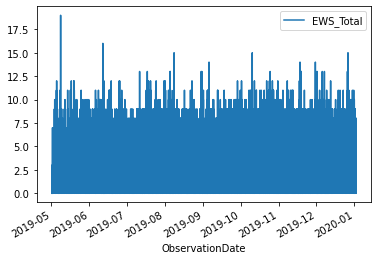

In [18]:
pivot = df.pivot_table(index=['ObservationDate'], values=['EWS_Total'], aggfunc='sum').plot()

print ('pivot')


In [19]:
plt.show()


In [20]:
# df = pd.DataFrame(['ObservationDate','EWS_Total','SBP','LOC','SpO2','Add_O2',HR','RR','TEMP'])
# pivot = df.pivot_table(index=['ObservationDate'], values=['HR'], aggfunc='min').plot()

# plt.show()

In [26]:
df_1 = df[['SBP','HR']]
df_1.index = df["ObservationDate"]
df_1


,SBP,HR
ObservationDate,,
2019-05-01 13:27:50,143.000000,80
2019-05-01 15:27:44,120.688665,83
2019-05-01 15:54:27,117.000000,75
2019-05-01 16:07:27,120.688665,85
2019-05-01 17:03:16,135.000000,89
...,...,...
2020-01-02 08:57:05,88.000000,72
2020-01-02 08:58:46,83.000000,79
2020-01-02 09:03:14,118.000000,82


<AxesSubplot:xlabel='ObservationDate'>

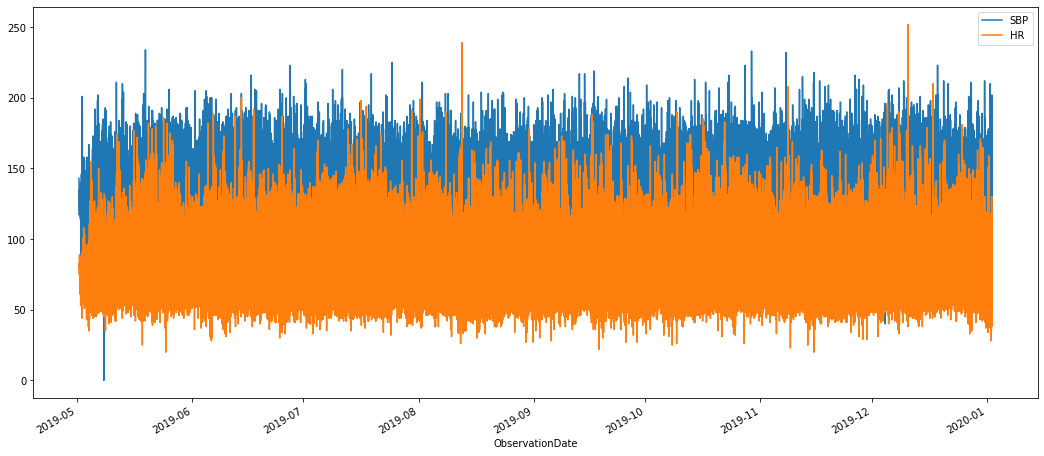

In [27]:
df_1.plot(figsize = (18,8))

In [33]:
df_2 = df[['EWS_Total','SBP','HR']]
df_2.index = df["ObservationDate"]
df_2

,EWS_Total,SBP,HR
ObservationDate,,,
2019-05-01 13:27:50,0,143.000000,80
2019-05-01 15:27:44,3,120.688665,83
2019-05-01 15:54:27,1,117.000000,75
2019-05-01 16:07:27,0,120.688665,85
2019-05-01 17:03:16,0,135.000000,89
...,...,...,...
2020-01-02 08:57:05,3,88.000000,72
2020-01-02 08:58:46,3,83.000000,79
2020-01-02 09:03:14,0,118.000000,82


<AxesSubplot:xlabel='ObservationDate'>

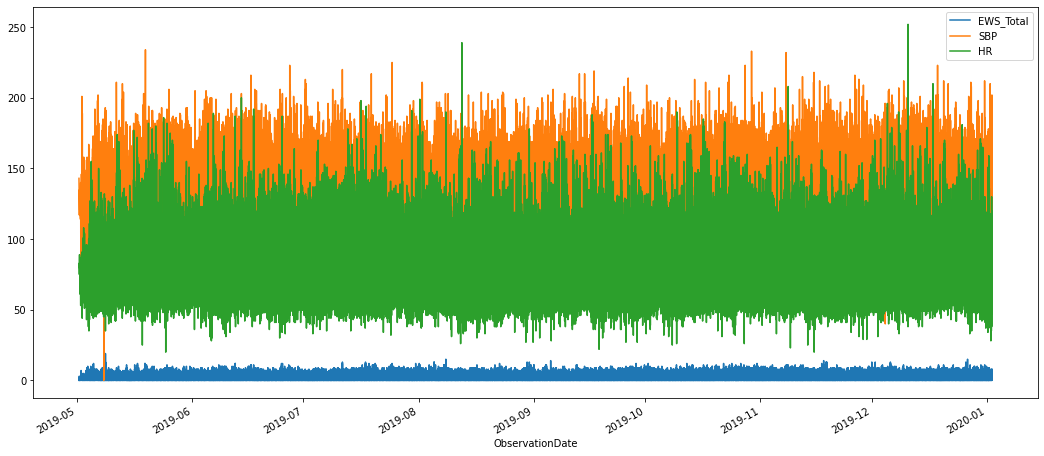

In [34]:
df_2.plot(figsize = (18,8))

## Timeseries data


